# 1. Introduction

In the ideal scenario for Machine Learning (ML) there are abundant labeled training instances, which share the same distribution as the test data [[1]](https://arxiv.org/abs/1911.02685?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%253A+arxiv%252FQSXk+%2528ExcitingAds%2521+cs+updates+on+arXiv.org%2529). However, these data can be resource intensive to collect or unrealistic in certain scenarios. Thus, Transfer Learning (TL) becomes a useful approach. It consists on the increasing learning ability of a model in one domain by transferring information from a different but related domain. In other words, it relaxes the hypothesis that the training and testing data are independent and identically distributed [[2]](https://link.springer.com/chapter/10.1007/978-3-030-01424-7_27). It only works if the features that are intended to be learned are general to both tasks. Traditional ML algorithms rely significantly on feature engineering, while Deep Learning (DL) focus on learning data by unsupervised or semi-supervised feature learning methods and hierarchical feature extraction. DL often requires massive amounts of data to be trained effectively, which makes it a strong candidate for TL.

Our task is to classifiy a series of labeled images. We are faced with two problems due to the small size of the dataset: the challenge to effectively learn the patterns in the data and the high probability of overfitting. We start by implementing a Convolutional Neural Network (CNN) model from scratch to be used as the benchmark model. Following the principle of TL we use a pre-trained Convolutional Neural Network ([[3]](https://arxiv.org/abs/1704.04861), [[4]](https://keras.io/api/applications/mobilenet/#mobilenetv2-function)) on the ImageNet dataset. We remove its top layers to include our own deep structure suited for our problem specifications. Thus, the pre-trained CNN works as a feature extraction layer in the overall new model. With this approach we are addressing both problems: we greatly reduce the requirement of a large training data while also reducing overfitting. To reduce even more the probability of overfitting we augment our training data by applying a suite of techniques that enhance the size and quality of the images. This method is defined as Data Augmentation (DA) and it is a regularization technique that while preserving the labels inflates the dataset by using transformations to add more invariant examples [[5]](https://arxiv.org/pdf/1708.06020.pdf).

In this article we use the Simpsons characters dataset [[6]](https://www.kaggle.com/alexattia/the-simpsons-characters-dataset). We filtered the dataset to only contain classes (characters) that contained more than 100 images. The resulting size of the dataset, after splitted between train, validation and test datasets is the following: 12411 images for training, 3091 images for vaildation and 950 for testing.

# 2. Data Preprocessing

Despite the size of the dataset being small to be effectively learned by a CNN, it is big enough for us to have memory issues when loading and transforming it. We use data generators to feed real-time the data to our different models. Generator functions are a special type of function that return a lazy iterator, i.e. they do not store their contents in memory. When creating the generator, we apply a transformation to normalize our data, split them between training and validation datasets and define a batch size of 32.

In [14]:
import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow.keras import Input, layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import tensorflow_hub as hub
from tensorflow.keras.layers import Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
directory_train = "./data/simpsons_data_split/train/"
directory_test = "./data/simpsons_data_split/test/"

In [16]:
def get_ImageDataGenerator(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                         validation_split=validation_split)
    return image_generator

In [17]:
image_gen_train = get_ImageDataGenerator(validation_split=0.2)

In [18]:
def get_generator(image_data_generator, directory, train_valid=None, seed=None):
    train_generator = image_data_generator.flow_from_directory(directory, 
                                                               batch_size=32, 
                                                               class_mode='categorical', 
                                                               target_size=(224,224), 
                                                               subset=train_valid, 
                                                               seed=seed)    
    return train_generator

In [19]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training', seed=1)
validation_generator = get_generator(image_gen_train, directory_train, train_valid='validation')

Found 12411 images belonging to 19 classes.
Found 3091 images belonging to 19 classes.


In [20]:
image_gen_test = get_ImageDataGenerator(validation_split=None)
test_generator = get_generator(image_gen_test, directory_test)

Found 950 images belonging to 19 classes.


We can iterate through our generators to get a set of images with the size equal to the batch size defined above.

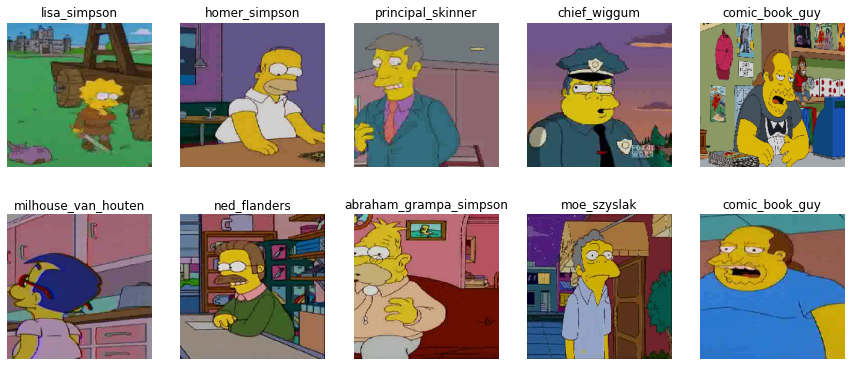

In [21]:
target_labels = next(os.walk(directory_train))[1]

target_labels.sort()

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

target_labels = np.asarray(target_labels)

plt.figure(figsize=(15,10))
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

# 3. The Benchmark Model

We define a simple CNN to be used as a benchmark model. It uses a combination of 2D convolution layers (to perform spatial convolution over images) with max pooling operations. These are followed by a dense layer with 128 units and ReLU activation function and a dropout layer with a rate of 0.5. Finally, the last layer yiels the output of our network, which has a number of units equal to the number of target labels and a softmax activation function. The model was compiled with the Adam optimiser with the default settings, categorical cross entropy loss and accuracy metric.

In [22]:
def get_benchmark_model(input_shape):
    x = Input(shape=input_shape)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = Conv2D(32, padding='same', kernel_size=(3,3), activation='relu')(x)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(64, padding='same', kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = Conv2D(128, kernel_size=(3,3), activation='relu')(h)
    h = MaxPooling2D(pool_size=(2,2))(h)
    h = Flatten()(h)
    h = Dense(128, activation='relu')(h)
    h = Dropout(.5)(h)
    output = Dense(target_labels.shape[0], activation='softmax')(h)

    model = tf.keras.Model(inputs=x, outputs=output)
    
    model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    return model

Bellow, one can find the summary of our model, with the detail of layers defined and number of parameters to train for each layer.

In [23]:
benchmark_model = get_benchmark_model((224, 224, 3))
benchmark_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 54, 54, 128)       7385

We trained the benchmark CNN model using an callback to stop the training process earlier if the validation accuracy is not improved for 3 epochs.

In [24]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size
    
    earlystopping = tf.keras.callbacks.EarlyStopping(patience=3)
    history = model.fit(train_gen, 
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        validation_data=valid_gen, 
                        callbacks=[earlystopping])
    
    return history

Every time that we use a generator we need to reset it before feeding it to a model, otherwise we will be loosing batches of data.

In [25]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training')
validation_generator = get_generator(image_gen_train, directory_train, train_valid='validation')

Found 12411 images belonging to 19 classes.
Found 3091 images belonging to 19 classes.


In [26]:
history_benchmark = train_model(benchmark_model, train_generator, validation_generator, 10)

Epoch 1/10
387/387 [==============================] - 762s 2s/step - loss: 2.6485 - accuracy: 0.1710 - val_loss: 2.1574 - val_accuracy: 0.3630
Epoch 2/10
308/387 [======================>.......] - ETA: 2:24 - loss: 2.0120 - accuracy: 0.3779


KeyboardInterrupt



The figure below shows the accuracy and loss evolution over time (epoch in this case) for the training and validation datasets. Clearly, our model is overfitting the data as the accuracy of the training is close to one and the accuracy of the validation dataset is actually decreasing for the last epochs. That is also the reason for the reduced the number of epochs that our model was trained on. 

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_benchmark.history['accuracy'])
plt.plot(history_benchmark.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_benchmark.history['loss'])
plt.plot(history_benchmark.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

We can evaluate our benchmark model by fitting it to our test dataset. The results are shown below.

In [ ]:
test_steps = test_generator.n // test_generator.batch_size
benchmark_test_loss, benchmark_test_acc = benchmark_model.evaluate(test_generator, steps=test_steps)
print('\nTest dataset:')
print("Loss: {}".format(benchmark_test_loss))
print("Accuracy: {}".format(benchmark_test_acc))

# 4. Pre-trained CNN

For the pre-trained model we used a light weight CNN ([[3]](https://arxiv.org/abs/1704.04861), [[4]](https://keras.io/api/applications/mobilenet/#mobilenetv2-function)) developed by Google and implemented in the `keras.applications` module. The CNN model has pre-trained parameters on the ImageNet dataset. We use the pre-trained CNN as a large feature extraction layer which we extend with an untrained set of layers specific for our multi-classification task. This is where the principle of TL is effectively applied.

In [ ]:
feature_extractor = tf.keras.applications.MobileNetV2(include_top=False, pooling='avg', input_shape=(128,128,3))

In [ ]:
base_model.summary()

In [ ]:
def add_new_classifier_head(feature_extractor_model):
    model = Sequential([
        feature_extractor_model,
        Dense(128, activation='relu'),
        Dropout(.5),
        Dense(target_labels.shape[0], activation='softmax')
    ])
    
    return model   

Below we can see the added layers to the head of our model, they are the exact same used as the top layers of the benchmark model.

In [ ]:
new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

In [ ]:
def freeze_pretrained_weights(model):
    model.get_layer(name='mobilenetv2_1.00_128').trainable=False
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

We freeze the pre-trained CNN parameters to be non-trainable - we can see that we have more than 2M non-trainable parameters in our new model.

In [ ]:
frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

In [ ]:
def train_model(model, train_gen, valid_gen, epochs):
    train_steps_per_epoch = train_gen.n // train_gen.batch_size
    val_steps = valid_gen.n // valid_gen.batch_size
    
    history = model.fit(train_gen, 
                        steps_per_epoch = train_steps_per_epoch,
                        epochs=epochs,
                        validation_data=valid_gen)
    
    return history

In [ ]:
history_frozen_new_model = train_model(frozen_new_model, train_generator, validation_generator, 20)

These are the same figures presented above but now for the new model. In this case, we don't see the same overfitting pattern, in fact we see that the model reaches its maximum accuracy very early, as one would expect with more than 90% of the weights already trained.

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_frozen_new_model.history['accuracy'])
plt.plot(history_frozen_new_model.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_new_model.history['loss'])
plt.plot(history_frozen_new_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

The results of fitting our new model to the test dataset are shown below.

In [ ]:
test_generator = get_generator(image_gen_test, directory_test)
new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(test_generator, steps=test_steps)
print('\nTest dataset')
print("Loss: {}".format(new_model_test_loss))
print("Accuracy: {}".format(new_model_test_acc))

# 5. Pre-trained CNN and Data Augmentation

As we saw above, DA is a set of methods used to increase the dataset while reducing overfitting. We focused on the generic DA that consists on geometric and photometric transformations (see [[5]](https://arxiv.org/pdf/1708.06020.pdf) for more information on these and other methods). Geometric transformations alter the geometry of the image, making the CNN invariant to change in position and orientation. On the other side, photometric transformations make the CNN invariant to changes in color and lighting by adjusting the color channels of the image.

In [ ]:
def get_ImageDataGenerator_augmented(validation_split=None):
    image_generator = ImageDataGenerator(rescale=(1/255.),
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.1,
                                        brightness_range=[0.8,1.2],
                                        horizontal_flip=True,
                                        validation_split=validation_split)
    return image_generator 

In [ ]:
image_gen_train_aug = get_ImageDataGenerator_augmented(validation_split=0.2)

In [ ]:
train_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='training', seed=1)
validation_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='validation')

In [ ]:
train_generator = get_generator(image_gen_train, directory_train, train_valid='training', seed=1)

We can display the original images and the augmented images for comparison. Notice the changes in geometry of the images such as by flipping, translation in vertical and horizontal directions or zooming, and in photometry, visible in the altered brightness of some images.

In [ ]:
batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

aug_batch = next(train_generator_aug)
aug_batch_images = np.array(aug_batch[0])
aug_batch_labels = np.array(aug_batch[1])

plt.figure(figsize=(16,5))
plt.suptitle("original images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(batch_images[i])
    plt.title(np.asarray(target_labels)[np.where(batch_labels[i] == 1.)[0][0]])
    plt.axis('off')
plt.figure(figsize=(16,5))
plt.suptitle("Augmented images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(aug_batch_images[i])
    plt.title(np.asarray(target_labels)[np.where(aug_batch_labels[i] == 1.)[0][0]])
    plt.axis('off')

In [ ]:
train_generator_aug = get_generator(image_gen_train_aug, directory_train, train_valid='training')

The augmented dataset is now fed to the same model defined above, which uses the pre-trained frozen weights.

In [ ]:
frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

In [ ]:
history_augmented = train_model(frozen_new_model, train_generator_aug, validation_generator_aug, epochs=50)

AHHHHHHHHHHHHHHHHHHHHHHH

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history_augmented.history['accuracy'])
plt.plot(history_augmented.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

The results of fitting our new model trained with the augmented dataset to the test dataset are shown below.

In [ ]:
test_generator = get_generator(image_gen_test, directory_test)
new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(test_generator, steps=test_steps)
print('\nTest dataset')
print("Loss: {}".format(new_model_test_loss))
print("Accuracy: {}".format(new_model_test_acc))

Finally, we can compare the training, validation and test metrics between the benchmark model, the new model defined using the principle of TL and the new model with the augmented data.

In [ ]:
benchmark_train_loss = history_benchmark.history['loss'][-1]
benchmark_valid_loss = history_benchmark.history['val_loss'][-1]
benchmark_train_acc = history_benchmark.history['acc'][-1]
benchmark_valid_acc = history_benchmark.history['val_acc'][-1]
benchmark_train_acc = history_benchmark.history['accuracy'][-1]
benchmark_valid_acc = history_benchmark.history['val_accuracy'][-1]

new_model_train_loss = history_frozen_new_model.history['loss'][-1]
new_model_valid_loss = history_frozen_new_model.history['val_loss'][-1]
new_model_train_acc = history_frozen_new_model.history['acc'][-1]
new_model_valid_acc = history_frozen_new_model.history['val_acc'][-1]
new_model_train_acc = history_frozen_new_model.history['accuracy'][-1]
new_model_valid_acc = history_frozen_new_model.history['val_accuracy'][-1]

augmented_model_train_loss = history_augmented.history['loss'][-1]
augmented_model_valid_loss = history_augmented.history['val_loss'][-1]
augmented_model_train_acc = history_augmented.history['acc'][-1]
augmented_model_valid_acc = history_augmented.history['val_acc'][-1]
augmented_model_train_acc = history_augmented.history['accuracy'][-1]
augmented_model_valid_acc = history_augmented.history['val_accuracy'][-1]

In [ ]:
comparison = pd.DataFrame([['Training loss', benchmark_train_loss, new_model_train_loss, augmented_model_train_loss],
                          ['Training accuracy', benchmark_train_acc, new_model_train_acc, augmented_model_train_acc],
                          ['Validation loss', benchmark_valid_loss, new_model_valid_loss, augmented_model_valid_loss],
                          ['Validation accuracy', benchmark_valid_acc, new_model_valid_acc, augmented_model_valid_acc],
                          ['Test loss', benchmark_test_loss, new_model_test_loss, augmented_model_test_loss],
                          ['Test accuracy', benchmark_test_acc, new_model_test_acc, augmented_model_test_acc]],
                           columns=['Metric', 'Benchmark CNN', 'Transfer Learning CNN', 'Transfer Learning w/ Data Augmentation CNN'])
comparison.index=['']*6
comparison

To illustrate the output of our network, we plot below predictions for a specific random image.

In [ ]:
# Get model predictions for the first batch of test data

test_generator = get_generator(image_gen, test_dir, seed=1)
predictions = frozen_new_model.predict(test_generator, steps=1)

In [ ]:
# Run this cell to view randomly selected images and model predictions

# Get images and ground truth labels
test_generator = get_generator(image_gen, test_dir, seed=1)
batches = []
for i in range(num_batches):
    batches.append(next(test_generator))
    
batch_images = np.vstack([b[0] for b in batches])
batch_labels = np.concatenate([b[1].astype(np.int32) for b in batches])

# Randomly select images from the batch
inx = np.random.choice(predictions.shape[0], 4, replace=False)
print(inx)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for n, i in enumerate(inx):
    axes[n, 0].imshow(batch_images[i])
    axes[n, 0].get_xaxis().set_visible(False)
    axes[n, 0].get_yaxis().set_visible(False)
    axes[n, 0].text(30., -3.5, lsun_classes[np.where(batch_labels[i] == 1.)[0][0]], 
                    horizontalalignment='center')
    axes[n, 1].bar(np.arange(len(predictions[i])), predictions[i])
    axes[n, 1].set_xticks(np.arange(len(predictions[i])))
    axes[n, 1].set_xticklabels(lsun_classes)
    axes[n, 1].set_title(f"Categorical distribution. Model prediction: {lsun_classes[np.argmax(predictions[i])]}")
    
plt.show()

# 6. Conclusion